# Installation and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_graphs(history, metric):
  """
    Plot graphs of the model's history

    Parameters:
        history:
            The history of the model
        metric:
            The metric to plot
  """
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Load data

In [105]:
import subprocess

DATASET_PATH = '../../../data/twitter-datasets/'
NEG_SAMPLES_PATH = DATASET_PATH + 'train_neg.txt'
POS_SAMPLES_PATH = DATASET_PATH + 'train_pos.txt'
FULL_NEG_SAMPLES_PATH = DATASET_PATH + 'train_neg_full.txt'
FULL_POS_SAMPLES_PATH = DATASET_PATH + 'train_pos_full.txt'

TRAIN_SPLIT = 0.8

def count_lines(filepath):
    with open(filepath, 'r') as f:
        return sum(1 for _ in f)

def load_data(full=False):
    neg_samples_path = FULL_NEG_SAMPLES_PATH if full else NEG_SAMPLES_PATH
    pos_samples_path = FULL_POS_SAMPLES_PATH if full else POS_SAMPLES_PATH

    # Count lines using wc -l
    neg_size = count_lines(neg_samples_path)
    pos_size = count_lines(pos_samples_path)

    # Load the samples and map them to a tuple with the label
    neg_samples = tf.data.TextLineDataset(neg_samples_path).map(lambda x: (x, 0))
    pos_samples = tf.data.TextLineDataset(pos_samples_path).map(lambda x: (x, 1))

    # Shuffle the samples
    neg_samples = neg_samples.shuffle(buffer_size=neg_size, reshuffle_each_iteration=False)
    pos_samples = pos_samples.shuffle(buffer_size=pos_size, reshuffle_each_iteration=False)

    # Split the samples into training and test sets
    neg_train_size = int(TRAIN_SPLIT * neg_size)
    pos_train_size = int(TRAIN_SPLIT * pos_size)

    neg_train = neg_samples.take(neg_train_size)
    neg_test = neg_samples.skip(neg_train_size)

    pos_train = pos_samples.take(pos_train_size)
    pos_test = pos_samples.skip(pos_train_size)

    # Concatenate the training and test sets
    train_data = tf.data.Dataset.concatenate(neg_train, pos_train)
    test_data = tf.data.Dataset.concatenate(neg_test, pos_test)

    train_data_size = neg_train_size + pos_train_size
    test_data_size = neg_size + pos_size - train_data_size

    # Shuffle the training and test sets
    train_data = train_data.shuffle(buffer_size=train_data_size, reshuffle_each_iteration=False).batch(16)
    test_data = test_data.shuffle(buffer_size=test_data_size, reshuffle_each_iteration=False).batch(16)

    print(f'Loaded {train_data_size} training samples and {test_data_size} test samples')

    return train_data, test_data, train_data_size, test_data_size

In [106]:
train_data, test_data, train_data_size, test_data_size = load_data(full=False)

Loaded 160000 training samples and 40000 test samples


# Create the text encoder

In [43]:
VOCAB_SIZE = 15000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.map(lambda text, label: text))

print(f"Vocabulary size: {len(encoder.get_vocabulary())}")

# Save the vocabulary to a file
vocab = encoder.get_vocabulary()
np.save('../../../data/vocab/RNN_vocab.npy', vocab)

Vocabulary size: 15000


2024-12-04 16:47:47.978139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
# Load the vocabulary from file
vocab = np.load('../../../data/vocab/RNN_vocab.npy', allow_pickle=True)

# Recreate the encoder and set its vocabulary
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.set_vocabulary(vocab)

print(f"Vocabulary size: {len(encoder.get_vocabulary())}")

Vocabulary size: 15000


# Build the model

Above is a diagram of the model.

1. This model can be build as a tf.keras.Sequential.

2. The first layer is the encoder, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. 
   An embedding layer stores one vector per word. 
   When called, it converts the sequences of word indices to sequences of vectors. 
   These vectors are trainable. 
   After training (on enough data), words with similar meanings often have similar vectors.

4. This index-lookup is much more efficient than the equivalent operation of passing a one-hot 
   encoded vector through a tf.keras.layers.Dense layer.

5. A recurrent neural network (RNN) processes sequence input by iterating through the elements. 
   RNNs pass the outputs from one timestep to their input on the next timestep.
   The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. 
   This propagates the input forward and backwards through the RNN layer and then concatenates 
   the final output.

   The main advantage of a bidirectional RNN is that the signal from the beginning of the input 
   doesn't need to be processed all the way through every timestep to affect the output.

   The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions
   as words are being added to the end.

6. After the RNN has converted the sequence to a single vector the two layers.
   Dense do some final processing, and convert from this vector representation to a single logit
   as the classification output.

In [59]:
# Hyperparameters
WORD_EMBEDDING_DIM = 128
BATCH_SIZE = 64
EPOCHS = 10

In [60]:
# Model creation
print(len(encoder.get_vocabulary()))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=WORD_EMBEDDING_DIM, mask_zero=True), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(WORD_EMBEDDING_DIM)),
    tf.keras.layers.Dense(WORD_EMBEDDING_DIM, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)])

# Model compilation
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    metrics=['accuracy'],
)

15000


# Train the model

In [61]:
TRAIN_STEPS_PER_EPOCH = train_data_size // BATCH_SIZE
TEST_STEPS = test_data_size // BATCH_SIZE

history = model.fit(
    train_data.repeat(), 
    epochs=EPOCHS,
    steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
    validation_data=test_data.repeat(), 
    validation_steps=TEST_STEPS,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - accuracy: 0.6168 - loss: 0.5931 - val_accuracy: 0.7692 - val_loss: 0.4479
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 79s 32ms/step - accuracy: 0.7708 - loss: 0.4502 - val_accuracy: 0.7766 - val_loss: 0.4226
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.7901 - loss: 0.4194 - val_accuracy: 0.7959 - val_loss: 0.4020
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.7931 - loss: 0.4120 - val_accuracy: 0.8018 - val_loss: 0.3958
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.8029 - loss: 0.3969 - val_accuracy: 0.8115 - val_loss: 0.3840
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.8100 - loss: 0.3862 - val_accuracy: 0.8042 - val_loss: 0.3942
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.8188 - loss: 0.3768 - val_accuracy: 0.8070 - val_loss: 0.3855


# Evaluate the model

In [62]:
test_loss, test_acc = model.evaluate(test_data, steps=TEST_STEPS)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8142 - loss: 0.3856
Test Loss: 0.3840053081512451
Test Accuracy: 0.8115000128746033


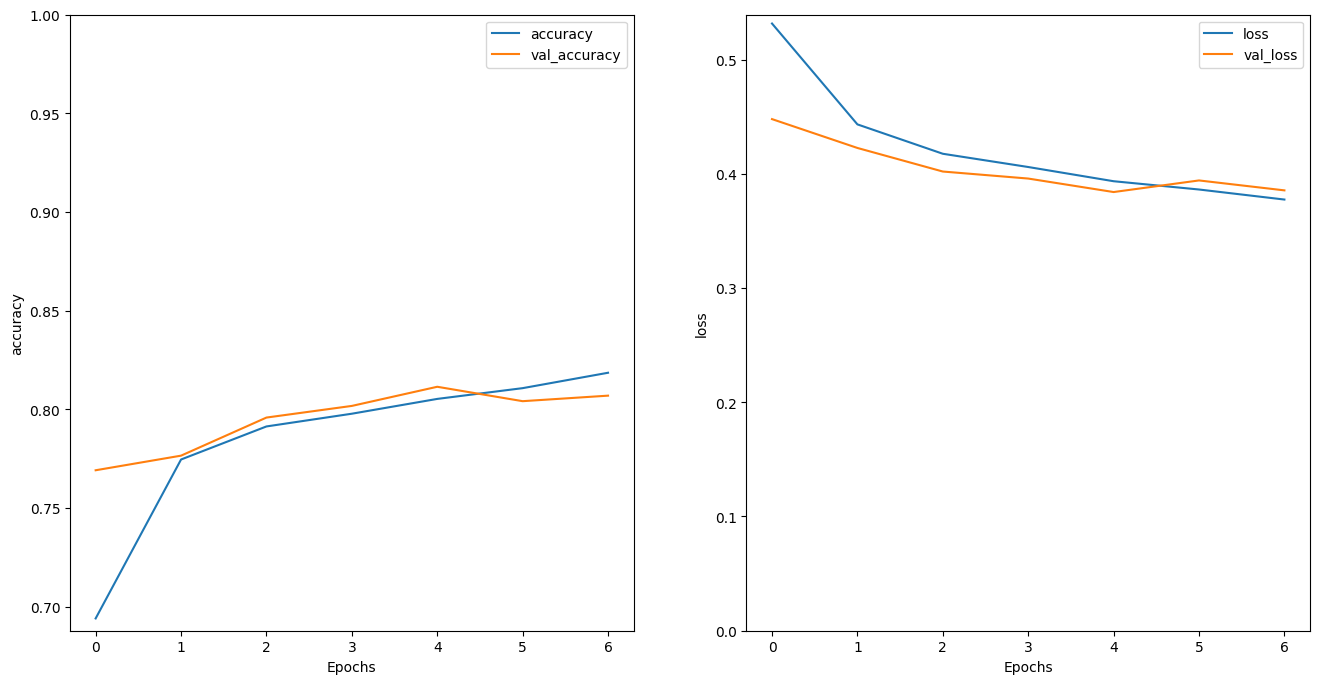

In [64]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()

# Build predictions

In [102]:
def predict(model, dataset):
    """
    Predict the sentiment of text data from a dataset.

    Args:
        model (tf.keras.Model): Trained model with TextVectorization layer.
        dataset (tf.data.Dataset): Dataset containing text samples.

    Returns:
        numpy.ndarray: Predicted probabilities for each input.
    """
    texts = list(dataset.as_numpy_iterator())
    input_batch = tf.constant(texts)

    predictions = model.predict(input_batch)
    binary_predictions = tf.nn.sigmoid(predictions)

    return binary_predictions

TEST_SAMPLES_PATH = DATASET_PATH + 'test_data.txt'

def load_submission_data():
    test_samples = tf.data.TextLineDataset(TEST_SAMPLES_PATH)
    return test_samples


In [104]:
# Load the submission data
submision_data = load_submission_data()

# Predict the sentiment of the submission data
predictions = predict(model, submision_data)

print(predictions.shape)
print(np.max(predictions))
print(np.min(predictions))

 17/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

2024-12-04 18:51:19.761932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
(10000, 1)
0.9953508
1.2928862e-07
